In [ ]:
!pip install git+https://github.com/nengo/nengo-dl.git

In [ ]:
!pip install nengo_loihi

In [4]:
import collections
import warnings

%matplotlib inline
import matplotlib.pyplot as plt
import nengo
import nengo_dl
import numpy as np
import tensorflow as tf

import nengo_loihi

np.random.seed(0)
tf.random.set_seed(0)

11493376/11490434 [==============================] - 0s 0us/step


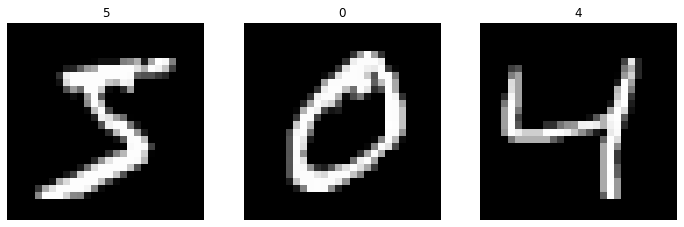

In [5]:
# load in MNIST dataset
(
    (train_images, train_labels),
    (test_images, test_labels),
) = tf.keras.datasets.mnist.load_data()

# flatten images and add time dimension
train_images = train_images.reshape((train_images.shape[0], 1, -1))
train_labels = train_labels.reshape((train_labels.shape[0], 1, -1))
test_images = test_images.reshape((test_images.shape[0], 1, -1))
test_labels = test_labels.reshape((test_labels.shape[0], 1, -1))

plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(np.reshape(train_images[i], (28, 28)), cmap="gray")
    plt.axis("off")
    plt.title(str(train_labels[i, 0, 0]))

In [6]:
inp = tf.keras.Input(shape=(28, 28, 1), name="input")

# transform input signal to spikes using trainable 1x1 convolutional layer
to_spikes_layer = tf.keras.layers.Conv2D(
    filters=3,  # 3 neurons per pixel
    kernel_size=1,
    strides=1,
    activation=tf.nn.relu,
    use_bias=False,
    name="to-spikes",
)
to_spikes = to_spikes_layer(inp)

# on-chip convolutional layers
conv0_layer = tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=3,
    strides=2,
    activation=tf.nn.relu,
    use_bias=False,
    name="conv0",
)
conv0 = conv0_layer(to_spikes)

conv1_layer = tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=3,
    strides=2,
    activation=tf.nn.relu,
    use_bias=False,
    name="conv1",
)
conv1 = conv1_layer(conv0)

flatten = tf.keras.layers.Flatten(name="flatten")(conv1)

dense0_layer = tf.keras.layers.Dense(units=100, activation=tf.nn.relu, name="dense0")
dense0 = dense0_layer(flatten)

# since this final output layer has no activation function,
# it will be converted to a `nengo.Node` and run off-chip
dense1 = tf.keras.layers.Dense(units=10, name="dense1")(dense0)

model = tf.keras.Model(inputs=inp, outputs=dense1)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
to-spikes (Conv2D)           (None, 28, 28, 3)         3         
_________________________________________________________________
conv0 (Conv2D)               (None, 13, 13, 32)        864       
_________________________________________________________________
conv1 (Conv2D)               (None, 6, 6, 64)          18432     
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense0 (Dense)               (None, 100)               230500    
_________________________________________________________________
dense1 (Dense)               (None, 10)               

In [7]:
def train(params_file="./keras_to_loihi_params", epochs=1, **kwargs):
    converter = nengo_dl.Converter(model, **kwargs)

    with nengo_dl.Simulator(converter.net, seed=0, minibatch_size=200) as sim:
        sim.compile(
            optimizer=tf.optimizers.RMSprop(0.001),
            loss={
                converter.outputs[dense1]: tf.losses.SparseCategoricalCrossentropy(
                    from_logits=True
                )
            },
            metrics={converter.outputs[dense1]: tf.metrics.sparse_categorical_accuracy},
        )
        sim.fit(
            {converter.inputs[inp]: train_images},
            {converter.outputs[dense1]: train_labels},
            epochs=epochs,
        )

        # save the parameters to file
        sim.save_params(params_file)

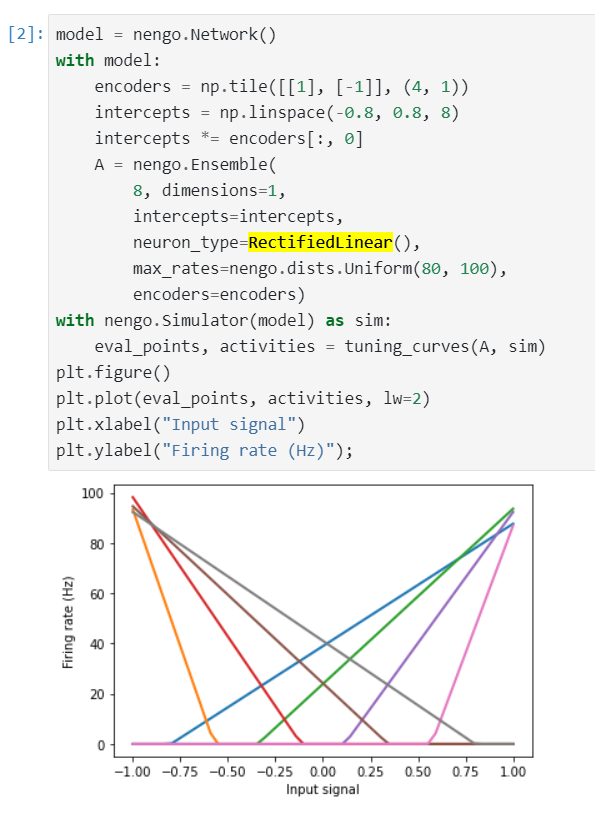

In [8]:
# train this network with normal ReLU neurons
train(
    epochs=2, swap_activations={tf.nn.relu: nengo.RectifiedLinear()},   # nengo ReLU neuron
)

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Train on 60000 samples
Epoch 1/2
60000/60000 [==============================] - 4s 60us/sample - loss: 0.1754 - probe_loss: 0.1754 - probe_sparse_categorical_accuracy: 0.9457
Epoch 2/2
60000/60000 [==============================] - 3s 58us/sample - loss: 0.0475 - probe_loss: 0.0475 - probe_sparse_categorical_accuracy: 0.9854


In [9]:
def run_network(
    activation,
    params_file="./keras_to_loihi_params",
    n_steps=30,
    scale_firing_rates=1,
    synapse=None,
    n_test=100,
    n_plots=2,
):
    # convert the keras model to a nengo network
    nengo_converter = nengo_dl.Converter(
        model,
        scale_firing_rates=scale_firing_rates,
        swap_activations={tf.nn.relu: activation},
        synapse=synapse,
    )

    # get input/output objects
    nengo_input = nengo_converter.inputs[inp]
    nengo_output = nengo_converter.outputs[dense1]

    # add probes to layers to record activity
    with nengo_converter.net:
        probes = collections.OrderedDict(
            [
                [to_spikes_layer, nengo.Probe(nengo_converter.layers[to_spikes])],
                [conv0_layer, nengo.Probe(nengo_converter.layers[conv0])],
                [conv1_layer, nengo.Probe(nengo_converter.layers[conv1])],
                [dense0_layer, nengo.Probe(nengo_converter.layers[dense0])],
            ]
        )

    # repeat inputs for some number of timesteps
    tiled_test_images = np.tile(test_images[:n_test], (1, n_steps, 1))

    # set some options to speed up simulation
    with nengo_converter.net:
        nengo_dl.configure_settings(stateful=False)

    # build network, load in trained weights, run inference on test images
    with nengo_dl.Simulator(
        nengo_converter.net, minibatch_size=20, progress_bar=False
    ) as nengo_sim:
        nengo_sim.load_params(params_file)
        data = nengo_sim.predict({nengo_input: tiled_test_images})

    # compute accuracy on test data, using output of network on
    # last timestep
    test_predictions = np.argmax(data[nengo_output][:, -1], axis=-1)
    print(
        "Test accuracy: %.2f%%"
        % (100 * np.mean(test_predictions == test_labels[:n_test, 0, 0]))
    )

    # plot the results
    mean_rates = []
    for i in range(n_plots):
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 3, 1)
        plt.title("Input image")
        plt.imshow(test_images[i, 0].reshape((28, 28)), cmap="gray")
        plt.axis("off")

        n_layers = len(probes)
        mean_rates_i = []
        for j, layer in enumerate(probes.keys()):
            probe = probes[layer]
            plt.subplot(n_layers, 3, (j * 3) + 2)
            plt.suptitle("Neural activities")

            outputs = data[probe][i]

            # look at only at non-zero outputs
            nonzero = (outputs > 0).any(axis=0)
            outputs = outputs[:, nonzero] if sum(nonzero) > 0 else outputs

            # undo neuron amplitude to get real firing rates
            outputs /= nengo_converter.layers[layer].ensemble.neuron_type.amplitude

            rates = outputs.mean(axis=0)
            mean_rate = rates.mean()
            mean_rates_i.append(mean_rate)
            print(
                '"%s" mean firing rate (example %d): %0.1f' % (layer.name, i, mean_rate)
            )

            if is_spiking_type(activation):
                outputs *= 0.001
                plt.ylabel("# of Spikes")
            else:
                plt.ylabel("Firing rates (Hz)")

            # plot outputs of first 100 neurons
            plt.plot(outputs[:, :100])

        mean_rates.append(mean_rates_i)

        plt.xlabel("Timestep")

        plt.subplot(1, 3, 3)
        plt.title("Output predictions")
        plt.plot(tf.nn.softmax(data[nengo_output][i]))
        plt.legend([str(j) for j in range(10)], loc="upper left")
        plt.xlabel("Timestep")
        plt.ylabel("Probability")

        plt.tight_layout()

    # take mean rates across all plotted examples
    mean_rates = np.array(mean_rates).mean(axis=0)

    return mean_rates


def is_spiking_type(neuron_type):
    return isinstance(neuron_type, (nengo.LIF, nengo.SpikingRectifiedLinear))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Test accuracy: 100.00%
"to-spikes" mean firing rate (example 0): 14.4
"conv0" mean firing rate (example 0): 2.0
"conv1" mean firing rate (example 0): 1.0
"dense0" mean firing rate (example 0): 2.9
"to-spikes" mean firing rate (example 1): 15.8
"conv0" mean firing rate (example 1): 2.3
"conv1" mean firing rate (example 1): 1.4
"dense0" mean firing rate (example 1): 3.6


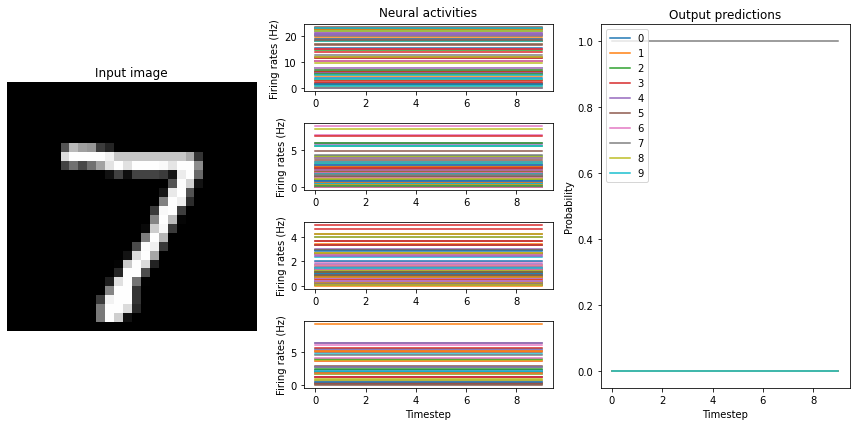

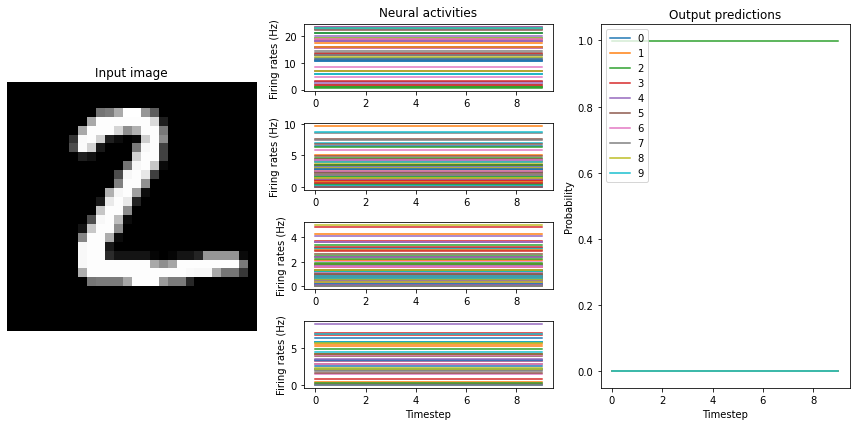

In [10]:

# test the trained networks on test set
mean_rates = run_network(activation=nengo.RectifiedLinear(), n_steps=10)

Test accuracy: 100.00%
"to-spikes" mean firing rate (example 0): 1452.9
"conv0" mean firing rate (example 0): 183.4
"conv1" mean firing rate (example 0): 97.3
"dense0" mean firing rate (example 0): 107.6
"to-spikes" mean firing rate (example 1): 1564.4
"conv0" mean firing rate (example 1): 207.6
"conv1" mean firing rate (example 1): 98.8
"dense0" mean firing rate (example 1): 122.9


array([1508.6841 ,  195.50052,   98.08736,  115.2381 ], dtype=float32)

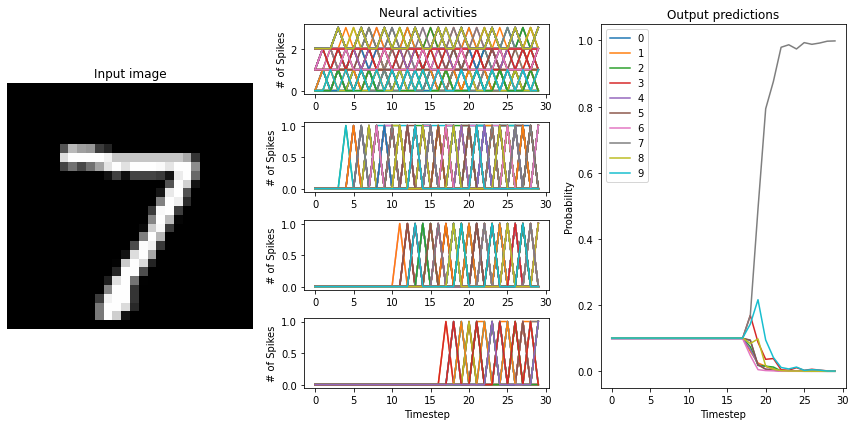

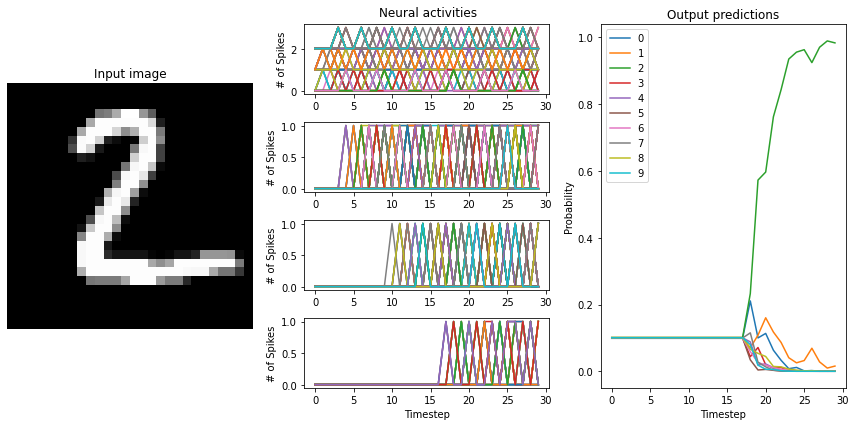

In [11]:
# test the trained networks using spiking neurons
run_network(
    activation=nengo.SpikingRectifiedLinear(), scale_firing_rates=100, synapse=0.005,
)